# SABR Volatility Model
------------------
> **Idriss Afra**

This project aims to construct the Equity implied volatility surface under the SABR model.

## Model Description

SABR is a dynamic model in which both the forward and the volatility are represented by stochastic state variables whose time evolution is given by the following system of stochastic differential equations :

$$
\begin{align}
dF_t & = \sigma_t F_t^\beta dW_t^1\\
\frac{d\sigma_t}{\sigma_t} & = \alpha dW_t^2\\
d<W^1,W^2>_t & = \rho dt
\end{align}
$$

Where :
* $F_0$ is the forward rate at $t = 0$
* $\sigma_0$ is the initial value of the volatility and controls the overall level of the volatility skew
* $\alpha$ is the volatility of the volatility and controls the convexity of the volatility skew
* $\beta$ is the forward exponent and controls the curvature of the volatility skew
* $\rho$ is the correlation between the forward and the volatility and controls the curvature of the volatility skew
* $W^1$ and $W^2$ are two $\rho$-correlated standard brownien motions

Under the SABR model, the prices of European call options are given by the Black's formula. In fact, for a current forward rate $F$, strike $K$, and implied volatility $\sigma_{SABR}(K, F)$, the price of an European call option with maturity T is :

$$
\begin{align}
C_{BLACK}(F_0, K, \sigma_{SABR}(K,F_0), T) & = e^{-rT} \left[ F_0 × N(d_1) - K × N(d_2) \right] \\
d_{1} & = \frac{ln\left(\frac{F_0}{K}\right) + \frac{1}{2} \sigma_{SABR}(K,F_0)^2 T}{\sigma_{SABR}(K,F_0) \sqrt{T}} \\
d_{2} & = d_{1} - \sigma_{SABR}(K,F_0) \sqrt{T}
\end{align}
$$

<br> Where $\sigma_{SABR}(K,F_0)$ follows the Hagan's formula (*2002 SABR Log-Normal Volatility expansion*) :

$$
\begin{align}
\sigma_{SABR}(K,F_0) & = \frac{\sigma_0 × \left[ 1 + \left( \frac{(1-\beta)^2}{24} × \frac{\sigma_0^2}{(F_0.K)^{1-\beta}} + \frac{1}{4} × \frac{\rho .\beta .\alpha .\sigma_0}{(F_0.K)^{(1-\beta)/2}} +\frac{\alpha^2 (2-3\rho^2)}{24} \right) × T \right]}{(F_0.K)^{(1-\beta)/2} × \left[1 + \frac{(1-\beta)^2}{24} ln^2\left(\frac{F_0}{K}\right) +  \frac{(1-\beta)^4}{1920} ln^4\left(\frac{F_0}{K}\right)\right]} × \frac{z}{\chi{(z)}} \\
z & = \frac{\alpha}{\sigma_0} × (F_0.K)^{(1-\beta)/2} × ln\left(\frac{F_0}{K}\right) \\
\chi{(z)} & = ln\left(\frac{\sqrt{1-2\rho z + z^2} + z - \rho}{1-\rho}\right)
\end{align}
$$
<br>This model is used to fit the implied volatility surface. However, it does not address potential implied market arbitrages and may even introduce new arbitrages for low strikes. As a result, arbitrage correction on market prices and the application of extrapolation methods for volatilities at extreme strikes are necessary.

In [1]:
import numpy as np

def sabr_vol(T, K, F0, sigma0, alpha, rho, beta=0.5):
    """
    Hagan's 2002 SABR log-normal vol expansion.
    The strike K can be a scalar or an array, the function returns an array of log-normal SABR vols.
    """
    eps = 1e-04
    fk_beta = (F0 * K)**(1 - beta)
    log_fk = np.log(F0/K)

    a = ((1 - beta)**2 / 24) * (sigma0**2 / fk_beta)
    b = 0.25 * rho * beta * alpha * sigma0 / fk_beta**0.5
    c = (2 - 3 * rho**2) * alpha**2 / 24
    d = fk_beta**0.5
    e = (1 - beta)**2 * log_fk**2 / 24
    f = (1 - beta)**4 * log_fk**4 / 1920
    z = alpha * fk_beta**0.5 * log_fk / sigma0

    # For close points to ATM, z and x(z) become close to zero and should be removed for the Hagan's formula
    num = sigma0 * (1 + (a + b + c) * T)
    num = np.where(abs(z) > eps, num * z, num)
    den = d * (1 + e + f)
    den = np.where(abs(z) > eps, den * x(rho, z), den)

    return num / den

def x(rho, z) :
    """
    Returns the function x, used in Hagan's 2002 SABR log-normal vol expansion.
    """
    num = (1 - 2 * rho * z + z**2)**0.5 + z - rho
    den = 1 - rho
    return  np.log (num / den)


## SABR Calibration Methods

In order to use the SABR model, we need to first calibrate its parameters : $\sigma_0$, $\alpha$, $\rho$, and $\beta$.

$\beta$ can be estimated by linear regression on a time series of logs of ATM market volatilities and logs of forward rates.

In fact :
$$
\sigma_{SABR}^{ATM}  = \sigma_{SABR}(K = F_0, F_0) ≈ \frac{\sigma_0}{F_0^{1-\beta}}
$$
And so :
$$
ln(\sigma_{SABR}^{ATM})  ≈ ln(\sigma_0) - (1-\beta) × ln(F_0)
$$
<br> In practice, $\beta$ is generally set manually at : $0.5$.
<br> For the initial calibration approach, we will treat it like the other parameters and use a global minimization process to replicate the market-implied volatilities. A second method will be introduced later for comparison.

Hence, for each market expiry $T$ :
$$
(\sigma_0^T, \alpha^T, \rho^T, \beta^T) = ArgMin_{(\sigma_0, \alpha, \rho, \beta)} \frac{1}{N_T} ∑_{K_i ∈ Market}\left(\sigma_{SABR}(K,F_0, \sigma_0, \alpha, \rho, \beta) - \sigma_{K_i, T}^{Market}\right)^{2}
$$



In [2]:
from scipy.optimize import minimize

def sabr_calibration_1(T, F0, strikes, vol_market):
    """
    1st calibration method.
    SABR model calibration : Sigma0, Alpha, Rho, and Beta.
    """
    # vol_market[len(vol_market) // 2] is the closest point vol to ATM
    parameters0 = np.array([vol_market[len(vol_market) // 2], 0.2, -0.2, 0.5]) # 0.2, -0.2, and 0.5 were chosen arbitrary
    res = minimize(obj_func_1, x0=parameters0, args=(T, F0, strikes, vol_market), bounds=((0.01, None), (0.01, None), 
                                                                                          (-0.99, 0.99), (0, 1)),
                  options={"maxiter" : 1000}, tol=1e-8)
    return list(res.x)

def obj_func_1(parameters, T, F0, strikes, vol_market) :
    """
    The Sum Squared Error function : Used as the objective function in the SABR Calibration.
    """
    sabr_volatilities = sabr_vol(T, strikes, F0, parameters[0], parameters[1], parameters[2], parameters[3])
    sse = 0
    for i in range(len(strikes)) :
        sse += (sabr_volatilities[i] - vol_market[i])**2
    return 10000 * sse / len(strikes)


Let's test this first calibration method :

Calibrated parameters :  {'Sigma0': 0.2242, 'Alpha': 0.8328, 'Rho': 0.0521, 'Beta': 0.8667}


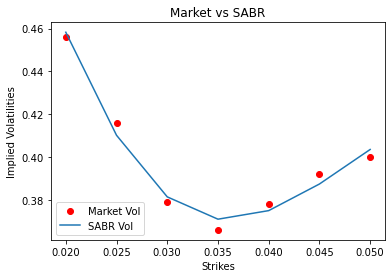

In [3]:
import matplotlib.pyplot as plt

# Test SABR Calibration : 1st Method.

# Arbitrary data for test
T = 1
S0 = 3.5 / 100
r = 2 / 100
discount = np.exp(-r * T)
F0 = S0 / discount

strikes  = np.array([2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]) / 100
vol_market = np.array([45.6, 41.6, 37.9, 36.6, 37.8, 39.2, 40.0]) / 100

params = sabr_calibration_1(T, F0, strikes, vol_market)
print("Calibrated parameters : ", {"Sigma0" : round(params[0], 4), "Alpha" : round(params[1], 4), 
                                   "Rho" : round(params[2], 4), "Beta" : round(params[3], 4)})

plt.ylabel("Implied Volatilities")
plt.xlabel("Strikes")
plt.title("Market vs SABR")
plt.scatter(strikes, vol_market, color="red", label="Market Vol")
vol_sabr = sabr_vol(T, strikes, F0, params[0], params[1], params[2], params[3])
plt.plot(strikes, vol_sabr, label="SABR Vol")
plt.legend(loc="lower left")
plt.show()

A more sophisticated method is based on calibrating $\alpha$, $\rho$, and $\beta$, by implying $\sigma_0$ from the ATM market volatility.

In fact :

$$
\sigma_{SABR}^{ATM}(K = F_0, F_0) = \frac{\sigma_0 × \left[1 + \left(\frac{(1-\beta)^2}{24} × \frac{\sigma_0^2}{F_0^{2-2\beta}} + \frac{1}{4} × \frac{\rho .\beta .\alpha .\sigma_0}{F_0^{2-2\beta}} +\frac{\alpha^2 (2-3\rho^2)}{24}\right) × T\right]}{F_0^{1-\beta}}
$$

And so :

$$
\frac{(1-\beta)^2.T}{24.F_0^{2-2\beta}} × \sigma_0^3 + \frac{1}{4} × \frac{\rho .\beta .\alpha.T}{F_0^{2-2\beta}} × \sigma_0^2 + \left[1 + \frac{\alpha^2 (2-3\rho^2)T}{24}\right] × \sigma_0 - \sigma^{ATM} F_0^{1-\beta} = 0
$$

Therefore : $\sigma_0(\alpha, \rho, \beta) $ is a real positive root of the above equation. In practice, we take the smallest real positive root.

For this calibration method, the minimization process changes to :

$$
(\sigma_0^T, \alpha^T, \rho^T, \beta^T) = ArgMin_{\left(\alpha, \rho, \beta\right)} \frac{1}{N_T} ∑_{K_i ∈ Market} \left( \sigma_{SABR}(K,F_0, \sigma_0(\alpha, \rho, \beta), \alpha, \rho, \beta) - \sigma_{K_i, T}^{Market} \right)^{2}
$$

Since $\sigma_0$ calibration depends strongly on the ATM volatility quote, this second method fit the ATM market volatilities better. It also reduces the probability of arbitrages for low strikes.

In [4]:
from scipy.optimize import minimize

def sabr_calibration_2(T, F0, strikes, vol_market) :
    """
    2nd calibration method.
    SABR model calibration : Sigma0, Alpha, Rho, and Beta.
    """
    parameters0 = np.array([0.2, -0.2, 0.5]) # 0.2, -0.2, and 0.5 were chosen arbitrary
    res = minimize(obj_func_2, x0=parameters0, args=(T, F0, strikes, vol_market), bounds=((0.01, None), (-0.99, 0.99), (0, 1)),
                  options={"maxiter" : 1000, "disp": True}, tol=1e-8)
    return [sigma0_implied(res.x, T, F0, strikes, vol_market)] + list(res.x)

def obj_func_2(parameters, T, F0, strikes, vol_market) :
    """
    The Sum Squared Error function : Used as the objective function in the SABR Calibration.
    """
    sigma0 = sigma0_implied(parameters, T, F0, strikes, vol_market)
    sabr_volatilities = sabr_vol(T, strikes, F0, sigma0, parameters[0], parameters[1], parameters[2])
    sse = 0
    for i in range(len(strikes)) :
        sse += (sabr_volatilities[i] - vol_market[i])**2
    return 10000 * sse / len(strikes)

def sigma0_implied(parameters, T, F0, strikes, vol_market) :
    """
    This function computes the smallest real positive root of the above cubic equation.
    """
    moneyness = strikes / F0
    moneyness -= 1
    # Search for the closest point to ATM
    atm_index = np.where(moneyness == min(abs(moneyness)))[0][0] if min(abs(moneyness)) in moneyness else np.where(moneyness == -min(abs(moneyness)))[0][0]
    atm_vol = vol_market[atm_index]

    f0_beta = F0**(2*(1 - parameters[2]))
    alpha = parameters[0]
    rho = parameters[1]
    a = ((1-parameters[2])**2 * T) / (24 * f0_beta)
    b = 0.25 * rho * parameters[2] * alpha * T / f0_beta**0.5
    c = 1 + alpha**2 * T * (2 - 3 * rho**2) / 24
    d = - atm_vol * f0_beta**0.5

    sigma0_roots = []
    for s0 in np.roots([a, b, c, d]) :
        if s0.imag == 0 and s0 > 0 :
            sigma0_roots += [s0.real]

    return min(sigma0_roots) if len(sigma0_roots) > 0 else sys.exit("The algorithm failed to converge. Please review the input data.")

Let's test this second method :

Calibrated parameters :  {'Sigma0': 0.3435, 'Alpha': 0.8879, 'Rho': -0.0016, 'Beta': 1.0}


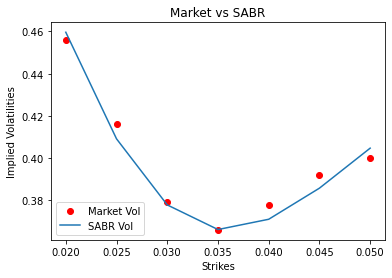

In [5]:
# Test SABR Calibration : 2nd Method.

import math
import matplotlib.pyplot as plt

strikes  = np.array([2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]) / 100
vol_market = np.array([45.6, 41.6, 37.9, 36.6, 37.8, 39.2, 40.0]) / 100

params = sabr_calibration_2(T, F0, strikes, vol_market)
print("Calibrated parameters : ", {"Sigma0" : round(params[0], 4), "Alpha" : round(params[1], 4), 
                                   "Rho" : round(params[2], 4), "Beta" : round(params[3], 4)})

plt.ylabel("Implied Volatilities")
plt.xlabel("Strikes")
plt.title("Market vs SABR")
plt.scatter(strikes, vol_market, color="red", label="Market Vol")
vol_sabr = sabr_vol(T, strikes, F0, params[0], params[1], params[2], params[3])
plt.plot(strikes, vol_sabr, label="SABR Vol")
plt.legend(loc="lower left")
plt.show()

## Application : CAC40 Listed Index Options

Now, let's apply the SABR model to construct the CAC40 implied volatility surface. To achieve this, we use the CAC40 implied forwards and volatilities as of February 12, 2025, computed in the following project : [Equity Implied Volatility Surface](https://github.com/Idriss-Afra/Equity-Implied-Volatility-Surface/blob/main/Equity%20Implied%20Volatility%20Surface.ipynb).

In [6]:
import datetime
import pandas as pd
from scipy.interpolate import interp1d

as_of_date = datetime.date(2025, 2, 12)
print("Analysis Date : ", as_of_date)
print("-----------------------------------------------")

eq_underlying = "CAC40"
S0 = 8042.19
print(eq_underlying + " Close Price : ", S0)
print("-----------------------------------------------")

option_data = pd.read_csv("MarketData/" + eq_underlying + "_MarketData_" + as_of_date.strftime('%d%m%Y') + ".csv")
print(eq_underlying + " Option Data :")
print(option_data)
print("-----------------------------------------------")

rate_underlying = "EURIBOR6M"
print(rate_underlying + " Zero-Coupon Rate Curve :")
rates_data = pd.read_csv("MarketData/" + rate_underlying +  "_ZCRates_" + as_of_date.strftime('%d%m%Y') + ".csv")
print(rates_data)

# ZC Rate : Cubic Interpolation & Extrapolation
zc_rate = interp1d(rates_data['Expiry'], rates_data['ZCRate'], kind='cubic', fill_value="extrapolate")

Analysis Date :  2025-02-12
-----------------------------------------------
CAC40 Close Price :  8042.19
-----------------------------------------------
CAC40 Option Data :
       Expiry   Strike    Call      Put  Repo+Dividend      Forward  \
0    0.024658   7925.0  151.83    27.92      -0.007517  8048.999044   
1    0.024658   7950.0  132.52    33.59      -0.007517  8048.999044   
2    0.024658   7975.0  114.13    40.18      -0.007517  8048.999044   
3    0.024658   8000.0   96.79    47.82      -0.007517  8048.999044   
4    0.024658   8025.0   81.15    57.17      -0.007517  8048.999044   
..        ...      ...     ...      ...            ...          ...   
137  4.857534   8000.0  977.10  1115.35       0.026932  7847.492862   
138  4.857534   8400.0  808.07  1308.91       0.026932  7847.492862   
139  4.857534   8800.0  665.26  1528.71       0.026932  7847.492862   
140  4.857534   9600.0  450.36  2039.01       0.026932  7847.492862   
141  4.857534  10400.0  312.97  2626.83       

First, let's gather the market data and store it in global dictionaries:

In [7]:
def collect_data(option_data):
    """
    Collects options market data and store it in dictionaries.
    """
    implied_forwards, strikes, implied_vols  = dict(), dict(), dict()
    expiries = np.sort(np.unique(option_data['Expiry']))
    for exp in expiries :
        df = option_data[option_data['Expiry'] == exp]
        implied_forwards[exp] = float(np.unique(df['Forward']))
        df = df.sort_values(by=['Strike'])
        strikes[exp], implied_vols[exp] = list(df['Strike']), list(df['Volatility']) 
    return {"Forwards" : implied_forwards, "Strikes" : strikes, "Volatilities" : implied_vols}    

# Collected Data
data = collect_data(option_data)
implied_forwards = data["Forwards"]
market_expiries = list(implied_forwards.keys())
strikes = data["Strikes"]
implied_vols = data["Volatilities"]


Then, let's clean the data and calibrate the SABR on the listed expiries:

CAC40 SABR Volatility Skews :


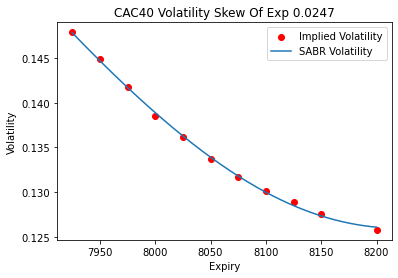

=> Convergence Error :  0.0
-----------------------------------------------------------


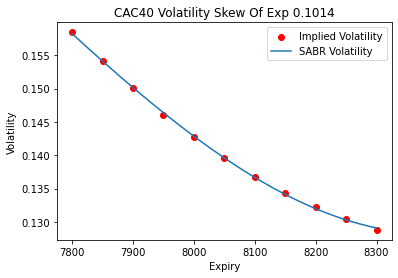

=> Convergence Error :  0.0
-----------------------------------------------------------


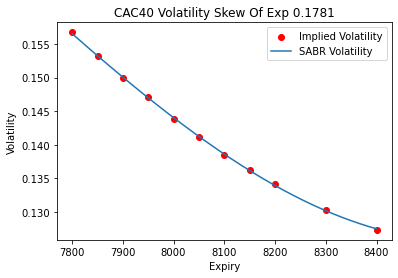

=> Convergence Error :  0.0
-----------------------------------------------------------


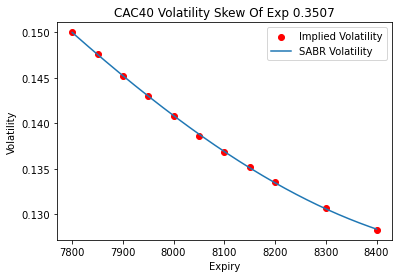

=> Convergence Error :  0.0
-----------------------------------------------------------


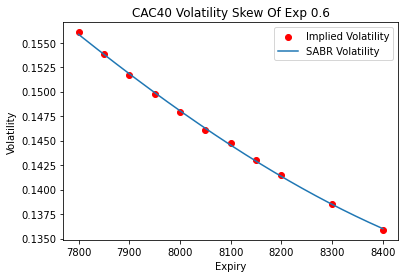

=> Convergence Error :  0.0
-----------------------------------------------------------


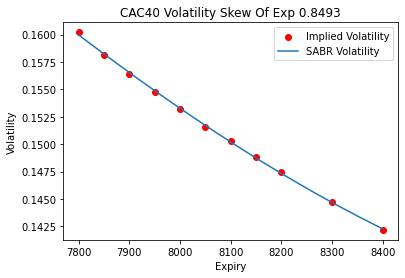

=> Convergence Error :  0.0
-----------------------------------------------------------


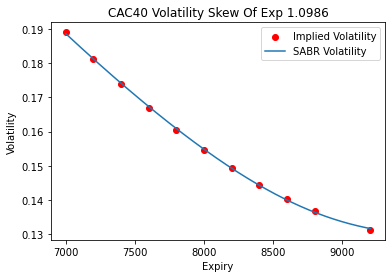

=> Convergence Error :  0.0
-----------------------------------------------------------


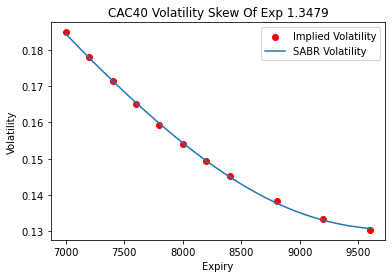

=> Convergence Error :  0.0
-----------------------------------------------------------


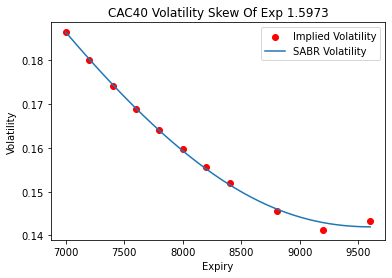

=> Convergence Error :  0.0
-----------------------------------------------------------


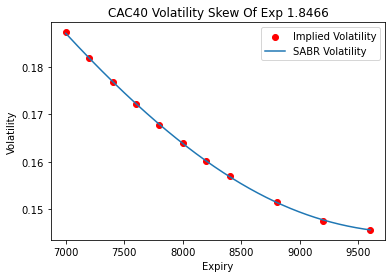

=> Convergence Error :  0.0
-----------------------------------------------------------
/!\ 2 strikes were filtered.


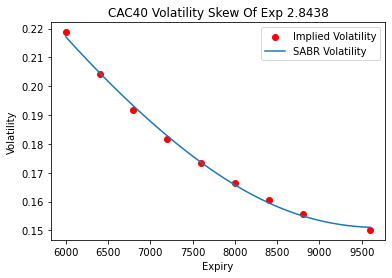

=> Convergence Error :  0.0
-----------------------------------------------------------
/!\ 2 strikes were filtered.


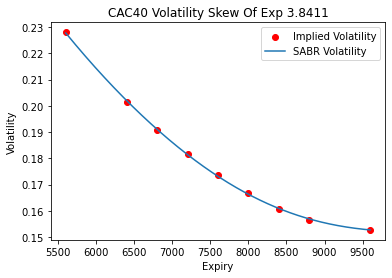

=> Convergence Error :  0.0
-----------------------------------------------------------
/!\ 1 strike was filtered.


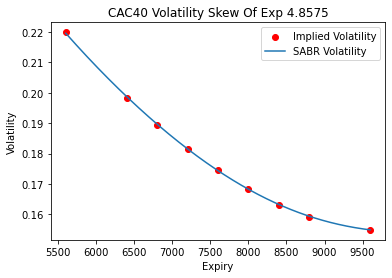

=> Convergence Error :  0.0
-----------------------------------------------------------


In [8]:
from scipy.stats import norm

def exercise_probability(exp, forward, strike, vol):
    """
    Computes the Black exercise probability.
    """
    phi = 1 if (strike > forward) else -1 # OTM Calls / Puts
    sqrt_v2T = np.sqrt(vol**2 * exp)
    d2 = np.log(forward / strike) / sqrt_v2T - 0.5 * sqrt_v2T
    return norm.cdf(phi * d2)
    

def clean_data(exp, forward, strikes, vols, min_moneyness = 0.7, max_moneyness = 1.3, min_exercise_proba=0.05):
    """
    Cleans the data before SABR calibration to avoid the SABR limitations on extreme strikes.
    The filters are based on moneyness and execise probabilities.
    """
    keep_index = [i for i in range(len(strikes)) if 
                 (strikes[i] / forward >= min_moneyness) and (strikes[i] / forward <= max_moneyness) and
                 exercise_probability(exp, forward, strikes[i], vols[i]) >= min_exercise_proba]
    nb_cleaned_data = len(strikes) - len(keep_index)
    word = " was " if nb_cleaned_data == 1 else "s were "
    if nb_cleaned_data > 0 : print("/!\ " + str(nb_cleaned_data) + " strike" + word + "filtered.")
    return np.array([strikes[i] for i in keep_index]), np.array([vols[i] for i in keep_index])

# SABR Volatility Skews
print(eq_underlying + " SABR Volatility Skews :")
sabr_params = dict()
for exp in market_expiries:
    cleaned_strikes, cleaned_vols = clean_data(exp, implied_forwards[exp], strikes[exp], implied_vols[exp])
    sabr_params[exp] = sabr_calibration_1(exp, implied_forwards[exp], np.array(cleaned_strikes), np.array(cleaned_vols))    
    plt.title(eq_underlying + " Volatility Skew Of Exp " + str(round(exp, 4)))
    plt.ylabel("Volatility")
    plt.xlabel("Expiry")
    plt.scatter(cleaned_strikes, cleaned_vols, color="red", label="Implied Volatility")
    x_axis = np.linspace(cleaned_strikes[0], cleaned_strikes[-1], 1000)
    vol_func = sabr_vol(exp, x_axis, implied_forwards[exp], sabr_params[exp][0], sabr_params[exp][1], sabr_params[exp][2], sabr_params[exp][3])
    plt.plot(x_axis, vol_func, label="SABR Volatility")
    plt.legend(loc="upper right")
    plt.show()
    print("=> Convergence Error : ", round(obj_func_1(sabr_params[exp], exp, implied_forwards[exp], cleaned_strikes, 
                                                      cleaned_vols) / 10000, 4))
    print("-----------------------------------------------------------")

Finally, we construct the SABR implied volatility surface:

In [9]:
def implied_vol(T, K, sabr_params, interp_meth='linear', min_moneyness = 0.7, max_moneyness = 1.3):
    """
    SABR implied vol.
    Expiry : interp_meth (Linear by Default) V2T interpolation - Flat Vol extrapolation.
    Strike : SABR log-normal vol expansion formula on [70% - 130%] - Flat vol extrapolation (To avoid the SABR limitations 
    on extreme strikes).
    """
    if (T <= market_expiries[0]) or (T >= market_expiries[-1]) or (T in market_expiries):
        exp = market_expiries[0] if (T <= market_expiries[0]) else \
             (market_expiries[-1] if (T >= market_expiries[-1]) else T)
        K = min(max_moneyness * implied_forwards[exp], max(min_moneyness * implied_forwards[exp], K))
        return sabr_vol(exp, K, implied_forwards[exp], sabr_params[exp][0], sabr_params[exp][1], sabr_params[exp][2], sabr_params[exp][3])
    else:
        expiries = market_expiries + [T]
        expiries.sort()
        index = expiries.index(T)
        # Prev
        T_prev = expiries[index - 1]
        sabr_params_prev = sabr_params[T_prev]
        K = min(max_moneyness * implied_forwards[T_prev], max(min_moneyness * implied_forwards[T_prev], K))
        vol_prev = sabr_vol(T_prev, K, implied_forwards[T_prev], sabr_params_prev[0], sabr_params_prev[1], 
                        sabr_params_prev[2], sabr_params_prev[3])
        # Next
        T_next = expiries[index + 1]
        sabr_params_next = sabr_params[T_next]
        K = min(max_moneyness * implied_forwards[T_next], max(min_moneyness * implied_forwards[T_next], K))
        vol_next = sabr_vol(T_next, K, implied_forwards[T_next], sabr_params_next[0], sabr_params_next[1], 
                        sabr_params_next[2], sabr_params_next[3])
        # Linear V2T
        return  np.sqrt(interp1d([T_prev, T_next], [vol_prev**2 * T_prev, vol_next**2 * T_next], kind=interp_meth)(T) / T)


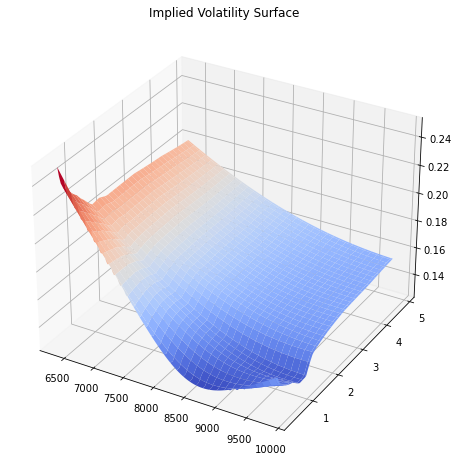

In [10]:
from matplotlib import cm

plt.rcParams["figure.figsize"] = (11,8)

K_min = 0.8 * max([min(strikes[exp]) for exp in market_expiries])
K_max = 1.2 * min([max(strikes[exp]) for exp in market_expiries])
K = np.linspace(K_min, K_max, 101, endpoint=True)
T = np.linspace(0.25, market_expiries[-1], 101, endpoint=True)
K, T = np.meshgrid(K, T)

def vol(K, T, total_var=False):
    vols = np.zeros(shape=K.shape)
    for t in range(vols.shape[0]):
        for k in range(vols.shape[1]):
            vol = implied_vol(T[t][k], K[t][k], sabr_params)
            vols[t, k] =  vol**2 * T[t][k] if total_var else vol
    return vols

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
surf = ax.plot_surface(K, T, vol(K, T), cmap=cm.coolwarm, linewidth=0, antialiased=True)
plt.title("Implied Volatility Surface")
plt.show()

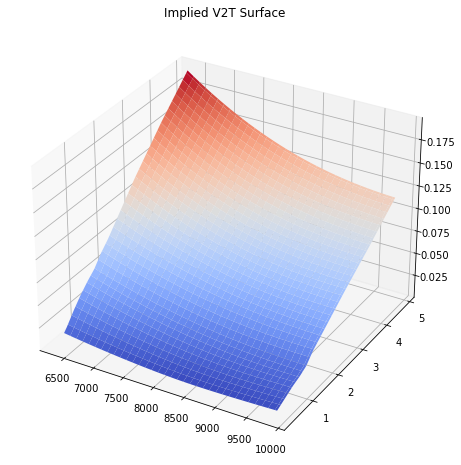

In [11]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
surf = ax.plot_surface(K, T, vol(K, T, True), cmap=cm.coolwarm, linewidth=0, antialiased=True)
plt.title("Implied V2T Surface")
plt.show()